11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


...........................................................................................................................................................................................................................................
Epoch 1 complete.
...........................................................................................................................................................................................................................................
Epoch 2 complete.
...........................................................................................................................................................................................................................................
Epoch 3 complete.
...........................................................................................................................................................................................................................................
Ep

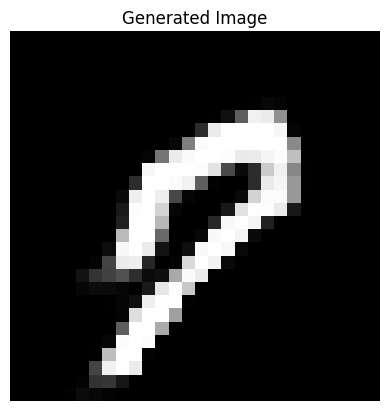

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Hyperparameters ---
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SHAPE = (28, 28, 1)  # MNIST images are 28x28 grayscale
NOISE_DIM = 100
EPOCHS = 50
SEED = tf.random.normal([16, NOISE_DIM])  # For generating consistent examples

# --- Load and Preprocess the MNIST Dataset ---
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype('float32')
train_images = (train_images - 127.5) / 127.5

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# --- Build the Generator ---
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

# Test the generator with random noise
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# plt.show()

# --- Build the Discriminator ---
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Output is a single value indicating real/fake

    return model

discriminator = make_discriminator_model()

# Test the discriminator on a generated image
decision = discriminator(generated_image)
# print(decision)

# --- Define Loss Functions and Optimizers ---
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# --- Training Loop ---
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm stats are not updated).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
            print('.', end='')
        print()

        # Produce images for the GIF as we go
        generate_and_save_images(generator,
                                 epoch + 1,
                                 SEED)

        print(f'Epoch {epoch + 1} complete.')

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    # Final generation
    generate_and_save_images(generator,
                             epochs,
                             SEED)

# --- Create Checkpoints (Optional but Recommended) ---
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# --- Train the Model ---
train(train_dataset, EPOCHS)

# --- Generate a GIF of the Training Progress (Optional) ---
import imageio.v2 as imageio

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = [f'image_at_epoch_{i+1:04d}.png' for i in range(EPOCHS)]
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filenames[-1])
    writer.append_data(image)

# --- Display the last generated image ---
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()